Please upload your IAQ CSV file (e.g., iaq_log_20251015_151722.csv)


Saving iaq_log_20251015_151722.csv to iaq_log_20251015_151722 (6).csv
Loaded: iaq_log_20251015_151722 (6).csv


/tmp/ipython-input-2639321819.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", len(first_seen_order))


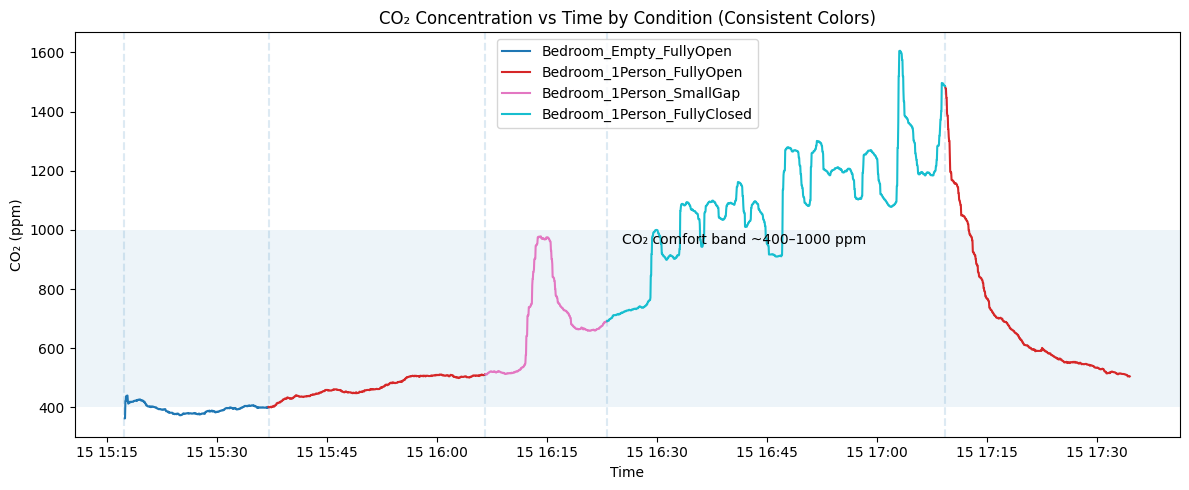

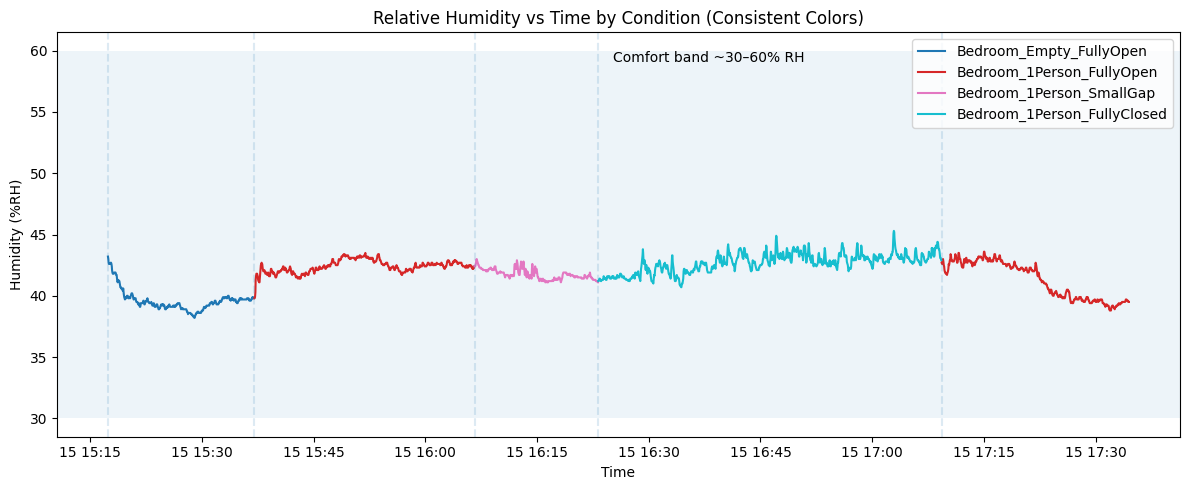


Summary by condition (mean/min/max):


co2_ppm                hum_bme              \
                                mean    min     max    mean   min   max   
condition_label                                                           
Bedroom_1Person_FullyClosed  1083.16  692.0  1606.0   42.69  40.7  45.3   
Bedroom_1Person_FullyOpen     569.86  400.0  1482.0   41.88  38.8  43.6   
Bedroom_1Person_SmallGap      680.13  511.0   978.0   41.75  41.1  43.0   
Bedroom_Empty_FullyOpen       395.47  363.0   440.0   39.59  38.2  43.2   

                            temp_bme             iaq_index              
                                mean   min   max      mean   min   max  
condition_label                                                         
Bedroom_1Person_FullyClosed    26.28  25.2  27.3     50.47  47.1  55.9  
Bedroom_1Person_FullyOpen      23.14  21.5  26.4     49.61  44.1  54.3  
Bedroom_1Person_SmallGap       24.09  22.7  25.2     51.48  49.3  54.5  
Bedroom_Empty_FullyOpen        22.99  22.3  24.4     48.92  44.5  51.3


Saved files:
 - fig_co2.png
 - fig_humidity.png
 - iaq_summary_by_condition.csv


In [9]:
# ================================
# IAQ RQ2 Plot & Summary
# ================================

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files

# ----------------
# 1) File upload
# ----------------
print("Please upload your IAQ CSV file (e.g., iaq_log_20251015_151722.csv)")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
csv_name = list(uploaded.keys())[0]
print(f"Loaded: {csv_name}")

# ----------------
# 2) Load & parse
# ----------------
df = pd.read_csv(io.BytesIO(uploaded[csv_name]))
required_min = ['iso_time','co2_ppm','hum_bme','condition_label']
missing = [c for c in required_min if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Columns found: {list(df.columns)}")

df['iso_time'] = pd.to_datetime(df['iso_time'], errors='coerce')
df = df.dropna(subset=['iso_time']).sort_values('iso_time').reset_index(drop=True)
df['co2_ppm'] = pd.to_numeric(df['co2_ppm'], errors='coerce')
df.loc[df['co2_ppm'] <= 0, 'co2_ppm'] = np.nan
df['hum_bme'] = pd.to_numeric(df['hum_bme'], errors='coerce')
for opt in ['temp_bme', 'iaq_index']:
    if opt not in df.columns:
        df[opt] = np.nan
    else:
        df[opt] = pd.to_numeric(df[opt], errors='coerce')

# Label order (first appearance)
first_seen_order = (
    df[['condition_label','iso_time']]
    .dropna()
    .groupby('condition_label', as_index=False)['iso_time']
    .min()
    .sort_values('iso_time')['condition_label']
    .tolist()
)

# ----------------
# 3) Contiguous runs + color map
# ----------------
df['run_id'] = (df['condition_label'] != df['condition_label'].shift()).cumsum()
runs = list(df.groupby(['condition_label','run_id']))
def label_order_key(cr):
    label = cr[0][0]
    try:
        return first_seen_order.index(label)
    except ValueError:
        return 1_000_000
runs.sort(key=label_order_key)

# Create color map (1 color per label)
palette = plt.cm.get_cmap("tab10", len(first_seen_order))
label_colors = {label: palette(i) for i, label in enumerate(first_seen_order)}

changes = df['condition_label'].ne(df['condition_label'].shift()).fillna(True)
change_times = df.loc[changes, 'iso_time'].tolist()
def mid_time(series): return series.iloc[len(series)//2]

# ----------------
# 4) Plot – CO₂ vs Time
# ----------------
plt.figure(figsize=(12,5))
plotted_labels = set()

for (label, run), g in runs:
    g = g.dropna(subset=['co2_ppm'])
    if g.empty: continue
    color = label_colors.get(label, "gray")
    show_label = (label not in plotted_labels)
    plt.plot(g['iso_time'], g['co2_ppm'], color=color, label=(label if show_label else None))
    if show_label:
        plotted_labels.add(label)

plt.axhspan(400, 1000, alpha=0.08)
plt.text(mid_time(df['iso_time']), 990, "CO₂ comfort band ~400–1000 ppm", va='top')
for ct in change_times: plt.axvline(ct, linestyle='--', alpha=0.15)

plt.title("CO₂ Concentration vs Time by Condition (Consistent Colors)")
plt.xlabel("Time")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_co2.png", dpi=150)
plt.show()

# ----------------
# 5) Plot – Humidity vs Time
# ----------------
plt.figure(figsize=(12,5))
plotted_labels = set()

for (label, run), g in runs:
    g = g.dropna(subset=['hum_bme'])
    if g.empty: continue
    color = label_colors.get(label, "gray")
    show_label = (label not in plotted_labels)
    plt.plot(g['iso_time'], g['hum_bme'], color=color, label=(label if show_label else None))
    if show_label:
        plotted_labels.add(label)

plt.axhspan(30, 60, alpha=0.08)
plt.text(mid_time(df['iso_time']), 60, "Comfort band ~30–60% RH", va='top')
for ct in change_times: plt.axvline(ct, linestyle='--', alpha=0.15)

plt.title("Relative Humidity vs Time by Condition (Consistent Colors)")
plt.xlabel("Time")
plt.ylabel("Humidity (%RH)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_humidity.png", dpi=150)
plt.show()

# ----------------
# 6) Summary Table
# ----------------
summary = (
    df.groupby('condition_label')[['co2_ppm','hum_bme','temp_bme','iaq_index']]
    .agg(['mean','min','max'])
    .round(2)
)
from IPython.display import display
print("\nSummary by condition (mean/min/max):")
display(summary)
summary.to_csv("iaq_summary_by_condition.csv")
print("\nSaved files:")
print(" - fig_co2.png")
print(" - fig_humidity.png")
print(" - iaq_summary_by_condition.csv")
